# CELL 1

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

# Thư viện Deep Learning Keras/TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

DATASET_PATH = "../DATASET_LABELED"
SAMPLE_RATE = 16000
DURATION = 4.0 
N_MFCC = 20

# Định nghĩa nhãn (Lưu ý: Bạn có 5 nhãn)
EMOTION_MAP = {
    "ANG": 0, # angry
    "ANX": 1, # anxious
    "HAP": 2, # happy
    "NEU": 3, # neutral
    "SAD": 4  # sad
}
# Đảo ngược để in kết quả sau này
idx_to_emotion = {v: k for k, v in EMOTION_MAP.items()}

print("Đã import xong!")

Đã import xong!


# CELL 2

In [2]:
# 1. Các hàm làm méo tiếng (Data Augmentation)
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# 2. Hàm xử lý độ dài (Padding/Truncate)
def pad_audio(data, sr, duration=4.0):
    input_length = int(sr * duration)
    if len(data) > input_length:
        # Nếu dài hơn 4s thì cắt bớt
        data = data[:input_length]
    else:
        # Nếu ngắn hơn 4s thì thêm số 0 vào đuôi (padding)
        padding = input_length - len(data)
        data = np.pad(data, (0, padding), 'constant')
    return data

# 3. Hàm tổng hợp để load và xử lý
def process_audio_file(file_path, augment=False):
    # Load file
    data, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Cắt khoảng lặng (Trim silence)
    data, _ = librosa.effects.trim(data, top_db=25)
    
    # Nếu yêu cầu augment (làm méo tiếng)
    if augment:
        # Random chọn 1 loại biến đổi để áp dụng
        choice = random.choice(['noise', 'stretch', 'shift', 'pitch'])
        if choice == 'noise': data = noise(data)
        elif choice == 'stretch': data = stretch(data)
        elif choice == 'shift': data = shift(data)
        elif choice == 'pitch': data = pitch(data, sr)
            
    # Ép về độ dài chuẩn 4s
    data = pad_audio(data, sr, DURATION)
    return data

# CELL 3

In [3]:
def extract_features(data, sr):
    # 1. ZCR
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512)
    # 2. RMS Energy
    rms = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    # 3. MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=N_MFCC, hop_length=512)
    
    # Ghép tất cả lại: Kết quả sẽ là (Số features, Thời gian)
    # Ví dụ: (1 + 1 + 20, 126) = (22, 126)
    features = np.concatenate((zcr, rms, mfcc), axis=0)
    
    # Chuyển vị ma trận thành (Thời gian, Số features) để đưa vào LSTM/CNN
    # Kết quả: (126, 22)
    return features.T 

print("Đã khai báo hàm trích xuất đặc trưng.")

Đã khai báo hàm trích xuất đặc trưng.


# CELL 4

In [4]:
X = []
y = []

print("Đang xử lý dữ liệu...")

# Duyệt qua các thư mục
for folder_name in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    
    # Chỉ xử lý nếu tên folder nằm trong map (ANG, HAP...)
    if os.path.isdir(folder_path) and folder_name in EMOTION_MAP:
        emotion_label = EMOTION_MAP[folder_name]
        print(f"-> Đang xử lý nhãn: {folder_name}")
        
        for file_path in glob.glob(os.path.join(folder_path, "*.wav")):
            # 1. Lấy dữ liệu gốc (Original)
            sig = process_audio_file(file_path, augment=False)
            feat = extract_features(sig, SAMPLE_RATE)
            X.append(feat)
            y.append(emotion_label)
            
            # 2. Tạo thêm dữ liệu giả (Augmentation)
            # Giúp tăng số lượng mẫu và model thông minh hơn
            # Tạo thêm 1 bản copy bị méo tiếng cho mỗi file gốc
            sig_aug = process_audio_file(file_path, augment=True)
            feat_aug = extract_features(sig_aug, SAMPLE_RATE)
            X.append(feat_aug)
            y.append(emotion_label)

# Chuyển sang mảng Numpy
X = np.array(X)
y = np.array(y)

# One-hot encoding cho nhãn (VD: nhãn 0 -> [1, 0, 0, 0, 0])
y_onehot = to_categorical(y, num_classes=5) # Bạn có 5 lớp

print("\nHoàn tất!")
print(f"Shape của X: {X.shape}") # (Số mẫu, Time_steps, Features)
print(f"Shape của y: {y_onehot.shape}")

# Chia Train/Test/Val
# Train: 80%, Test: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Đang xử lý dữ liệu...
-> Đang xử lý nhãn: ANG
-> Đang xử lý nhãn: ANX
-> Đang xử lý nhãn: HAP
-> Đang xử lý nhãn: NEU
-> Đang xử lý nhãn: SAD

Hoàn tất!
Shape của X: (3016, 126, 22)
Shape của y: (3016, 5)
Train samples: 2170
Test samples: 604


# CELL 5

In [5]:
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Lấy shape đầu vào từ dữ liệu đã xử lý
input_shape = (X_train.shape[1], X_train.shape[2]) # (Time_steps, Features)
num_classes = 5 # ANG, ANX, HAP, NEU, SAD

# CELL 6 Model 1 - LSTM (Long Short-Term Memory)

In [6]:
model_lstm = Sequential([
    Input(shape=input_shape),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_lstm.summary())

history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, 
                              validation_data=(X_val, y_val), 
                              callbacks=[rlrop, early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 126, 128)       │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,205 (512.52 KB)

 Trainable params: 131,205 (512.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4917 - loss: 1.3546 - val_accuracy: 0.5289 - val_loss: 1.2993 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5364 - loss: 1.2566 - val_accuracy: 0.5579 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5774 - loss: 1.1912 - val_accuracy: 0.5702 - val_loss: 1.2199 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5889 - loss: 1.1404 - val_accuracy: 0.5620 - val_loss: 1.1920 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6198 - loss: 1.0561 - val_accuracy: 0.5702 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6359 - loss: 1.0000 - val_accuracy: 0.5702 - val_loss: 1.1542 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6590 - loss: 0.9663 - va

# CELL 7 Model 2 - Bi-LSTM (Bidirectional LSTM)

In [7]:
model_bilstm = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_bilstm = model_bilstm.fit(X_train, y_train, epochs=50, batch_size=32, 
                                  validation_data=(X_val, y_val), 
                                  callbacks=[rlrop, early_stopping])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4788 - loss: 1.3840 - val_accuracy: 0.5041 - val_loss: 1.3301 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5290 - loss: 1.2557 - val_accuracy: 0.5248 - val_loss: 1.2546 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5502 - loss: 1.2033 - val_accuracy: 0.5455 - val_loss: 1.2410 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5820 - loss: 1.1393 - val_accuracy: 0.5289 - val_loss: 1.1788 - learning_rate: 0.0010
Epoch 5/50
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6153 - loss: 1.0637
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6069 - loss: 1.0808 - val_accuracy: 0.5413 - val_loss: 1.1556 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6438 - loss: 0.9845 - val_accu

# CELL 8 Model 3 - CNN (Convolutional Neural Network 1D)

In [8]:
model_cnn = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, 
                            validation_data=(X_val, y_val), 
                            callbacks=[rlrop, early_stopping])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4682 - loss: 1.5902 - val_accuracy: 0.5083 - val_loss: 1.3126 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6240 - loss: 1.0196 - val_accuracy: 0.5248 - val_loss: 1.1543 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7023 - loss: 0.8059 - val_accuracy: 0.5868 - val_loss: 1.0467 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7899 - loss: 0.5615 - val_accuracy: 0.6446 - val_loss: 1.0651 - learning_rate: 0.0010
Epoch 5/50
62/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8428 - loss: 0.4482
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8415 - loss: 0.4503 - val_accuracy: 0.6694 - val_loss: 1.1046 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9207 - loss: 0.2474 - val_accuracy: 

# Cell 9 

SO SÁNH KẾT QUẢ CÁC MODEL

LSTM:
  Test Loss: 1.0985
  Test Accuracy: 65.23%

Bi-LSTM:
  Test Loss: 1.0478
  Test Accuracy: 61.09%

CNN:
  Test Loss: 1.2754
  Test Accuracy: 50.83%

🏆 MODEL TỐT NHẤT: LSTM với accuracy 65.23%


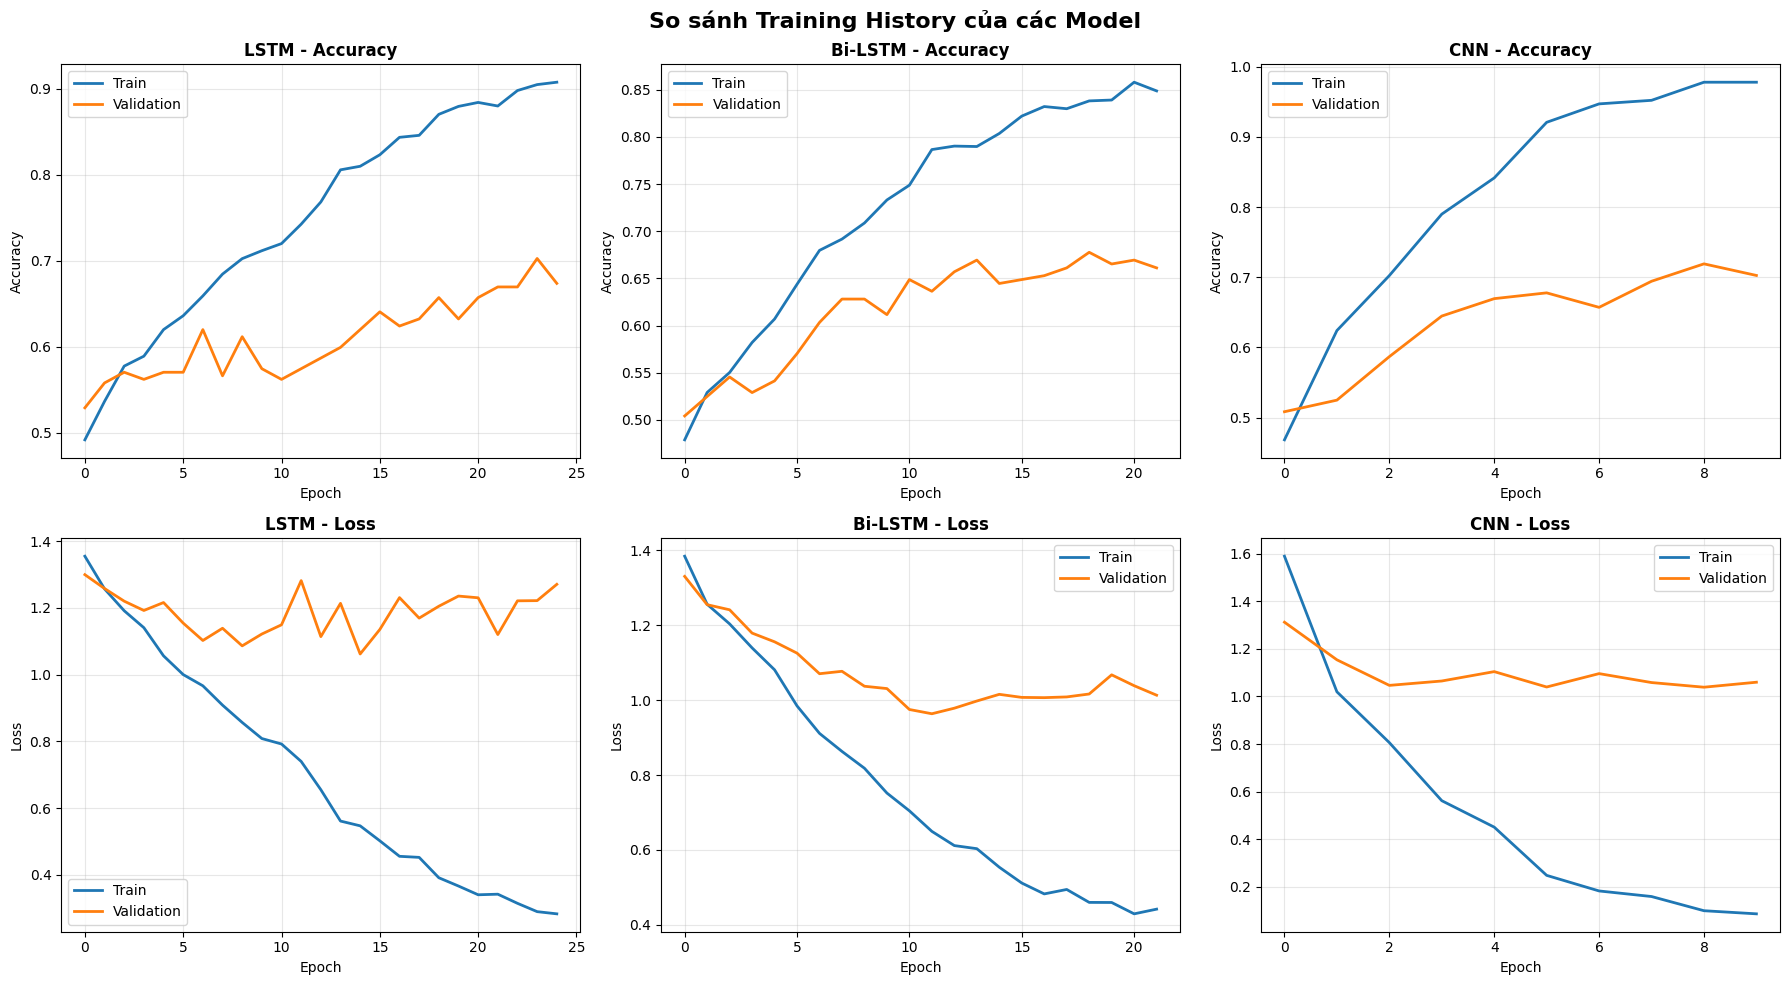

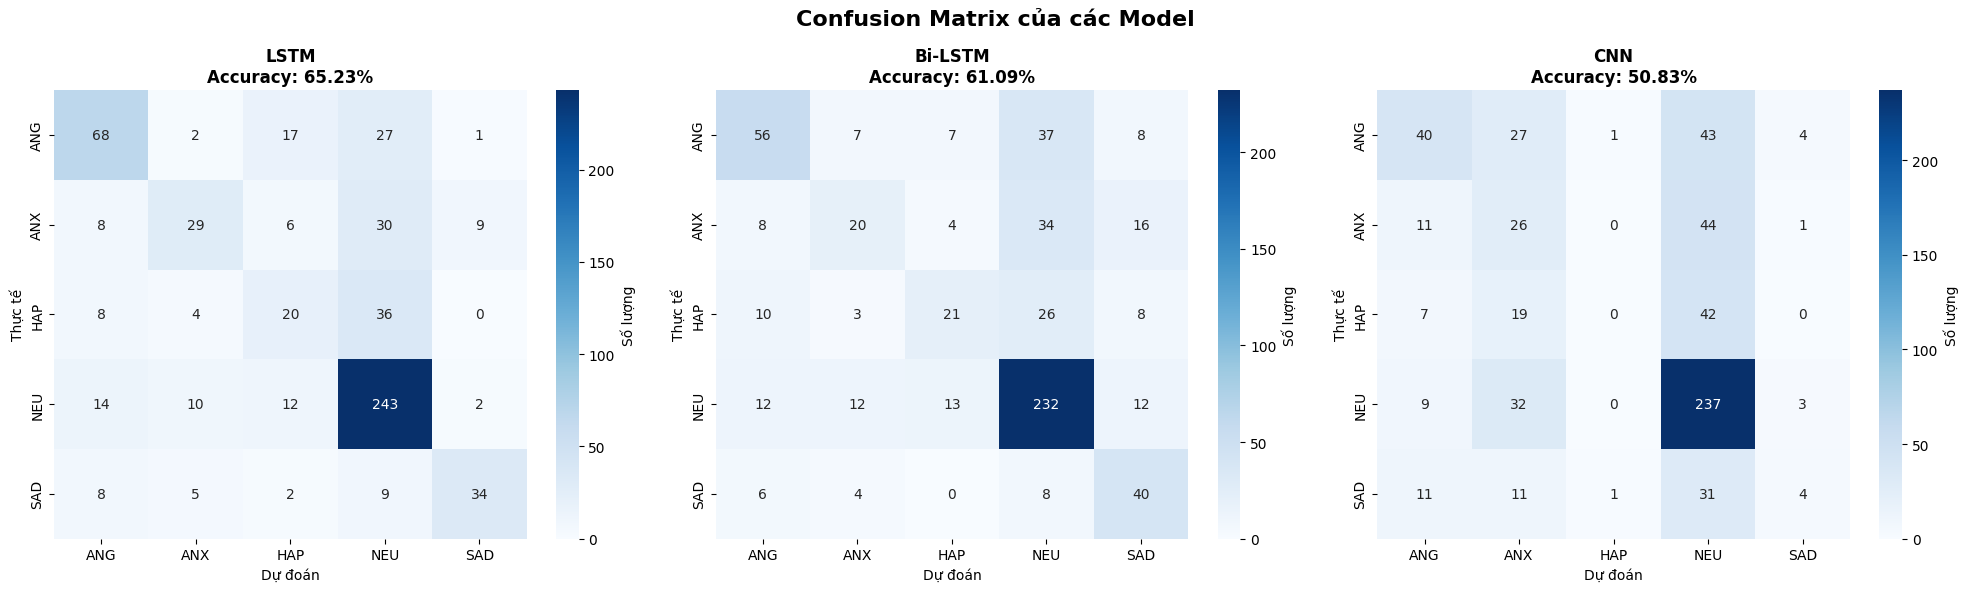


CLASSIFICATION REPORT CHO LSTM (Model tốt nhất)
              precision    recall  f1-score   support

         ANG     0.6415    0.5913    0.6154       115
         ANX     0.5800    0.3537    0.4394        82
         HAP     0.3509    0.2941    0.3200        68
         NEU     0.7043    0.8648    0.7764       281
         SAD     0.7391    0.5862    0.6538        58

    accuracy                         0.6523       604
   macro avg     0.6032    0.5380    0.5610       604
weighted avg     0.6390    0.6523    0.6368       604



In [9]:
# So sánh và đánh giá cả 3 model
models = {
    'LSTM': (model_lstm, history_lstm),
    'Bi-LSTM': (model_bilstm, history_bilstm),
    'CNN': (model_cnn, history_cnn)
}

print("="*60)
print("SO SÁNH KẾT QUẢ CÁC MODEL")
print("="*60)

results = {}
for model_name, (model, history) in models.items():
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results[model_name] = {'loss': loss, 'accuracy': acc}
    print(f"\n{model_name}:")
    print(f"  Test Loss: {loss:.4f}")
    print(f"  Test Accuracy: {acc*100:.2f}%")

# Tìm model tốt nhất
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print("\n" + "="*60)
print(f"🏆 MODEL TỐT NHẤT: {best_model_name} với accuracy {results[best_model_name]['accuracy']*100:.2f}%")
print("="*60)

# 1. Vẽ đồ thị Loss và Accuracy cho cả 3 model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('So sánh Training History của các Model', fontsize=16, fontweight='bold')

for idx, (model_name, (model, history)) in enumerate(models.items()):
    # Accuracy
    axes[0, idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, idx].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, idx].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Loss
    axes[1, idx].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1, idx].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1, idx].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Vẽ Confusion Matrix cho cả 3 model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrix của các Model', fontsize=16, fontweight='bold')

for idx, (model_name, (model, history)) in enumerate(models.items()):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=list(EMOTION_MAP.keys()), 
                yticklabels=list(EMOTION_MAP.keys()),
                cbar_kws={'label': 'Số lượng'})
    axes[idx].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]*100:.2f}%', 
                        fontweight='bold')
    axes[idx].set_xlabel('Dự đoán')
    axes[idx].set_ylabel('Thực tế')

plt.tight_layout()
plt.show()

# 3. Classification Report chi tiết cho model tốt nhất
print("\n" + "="*60)
print(f"CLASSIFICATION REPORT CHO {best_model_name} (Model tốt nhất)")
print("="*60)
best_model = models[best_model_name][0]
y_pred_best = best_model.predict(X_test, verbose=0)
y_pred_classes_best = np.argmax(y_pred_best, axis=1)
y_true_best = np.argmax(y_test, axis=1)

print(classification_report(y_true_best, y_pred_classes_best, 
                          target_names=list(EMOTION_MAP.keys()),
                          digits=4))